In [1]:
import shap
import transformers
import torch
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

In [2]:
# load BERT model
model_name = "bert-base-multilingual-cased"
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)
model = transformers.BertForSequenceClassification.from_pretrained(model_name, num_labels=2).cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [2]:
# load XLM-Roberta model
model_name = "xlm-roberta-base"
tokenizer = transformers.XLMRobertaTokenizer.from_pretrained(model_name)
model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2).cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

In [1]:
dataset = {'label' : [], 'text': []}
f = open("./IronyTR Dataset/ironic.txt", "r",  encoding="utf8")
lines = f.readlines()

for line in lines:
    dataset['text'].append(line)
    dataset['label'].append(1)
    
f.close()

f = open("./IronyTR Dataset/non-ironic.txt", "r",  encoding="utf8")
lines = f.readlines()

for line in lines:
    dataset['text'].append(line)
    dataset['label'].append(0)
    
f.close()

C:\Users\frat1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


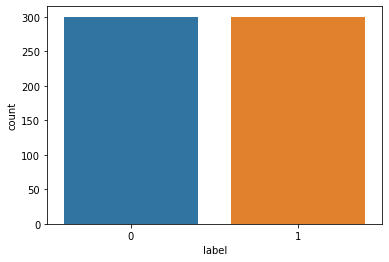

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(dataset['label'])
plt.xlabel('label');

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['label'], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [5]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [6]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

# Fine-tune pretrained model

In [7]:
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [8]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

wandb: Currently logged in as: adnanhd (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss,Validation Loss


TrainOutput(global_step=162, training_loss=0.5137760492018711, metrics={'train_runtime': 20.586, 'train_samples_per_second': 7.869, 'total_flos': 43868793748032.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 2146353152, 'init_mem_gpu_alloc_delta': 443266560, 'init_mem_cpu_peaked_delta': 314634240, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 23736320, 'train_mem_gpu_alloc_delta': 1332453376, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 363052032})

In [9]:
trainer.evaluate()

{'eval_loss': 0.5082433223724365,
 'eval_accuracy': 0.75,
 'eval_precision': 0.6956521739130435,
 'eval_recall': 0.7619047619047619,
 'eval_f1': 0.7272727272727272,
 'eval_runtime': 0.0972,
 'eval_samples_per_second': 494.037,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 540672,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 9374720}

In [10]:
model_path = "output/dbmdz_checkpoint-50000"
model.save_pretrained(model_path)

In [13]:
# ----- 3. Predict -----#
# Load test data
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
#model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)
#model = transformers.BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [27]:
# Prediction results of Bert multilingual model
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Accuracy:  0.625
Recall:  0.45614035087719296
Precision:  0.65
F1:  0.5360824742268041


In [13]:
# Prediction results of XLM-Roberta base model
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Accuracy:  0.575
Recall:  0.9
Precision:  0.4945054945054945
F1:  0.6382978723404256


In [14]:
# Prediction results of dbmdz/BertTurk model
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

Accuracy:  0.725
Recall:  0.71875
Precision:  0.7540983606557377
F1:  0.7359999999999999


# Explain Transformer Models with Shap 

In [4]:
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=512, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

In [5]:
# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

explainers.Partition is still in an alpha state, so use with caution...


In [6]:
shap_values = explainer(dataset, fixed_context=1)

Partition explainer: 601it [05:58,  1.64it/s]


# BERT Multilingual

In [8]:
# plot the first sentence's explanation
shap.plots.text(shap_values[2])

In [9]:
# plot the first sentence's explanation
shap.plots.text(shap_values[25])

In [10]:
# plot the first sentence's explanation
shap.plots.text(shap_values[40])

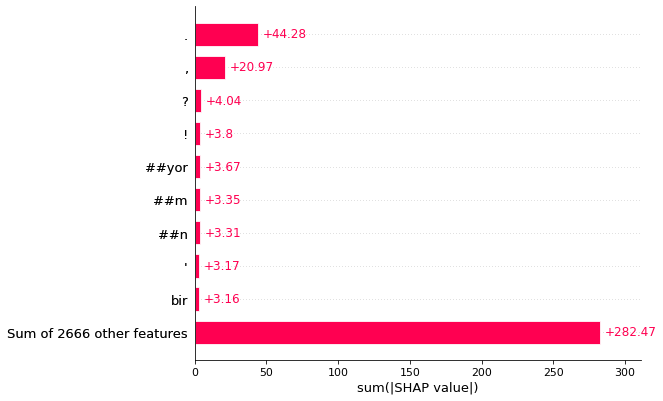

In [11]:
shap.plots.bar(shap_values.abs.sum(0))

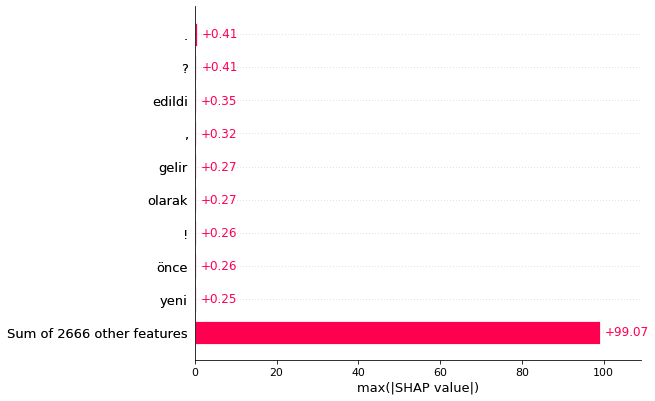

In [12]:
shap.plots.bar(shap_values.abs.max(0))

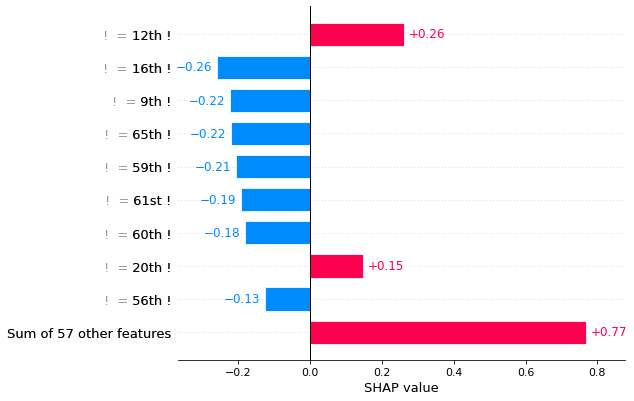

In [13]:
shap.plots.bar(shap_values[:,"!"])

# XLM-Roberta

In [7]:
# plot the first sentence's explanation
shap.plots.text(shap_values[2])

In [8]:
# plot the first sentence's explanation
shap.plots.text(shap_values[25])

In [9]:
# plot the first sentence's explanation
shap.plots.text(shap_values[40])

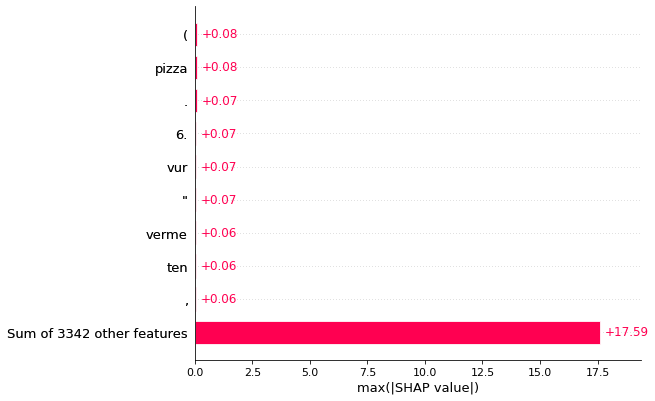

In [10]:
shap.plots.bar(shap_values.abs.max(0))

# Turkish Bert

In [12]:
# plot the first sentence's explanation
shap.plots.text(shap_values[2])

In [18]:
# plot the first sentence's explanation
shap.plots.text(shap_values[25])

In [21]:
# plot the first sentence's explanation
shap.plots.text(shap_values[40])

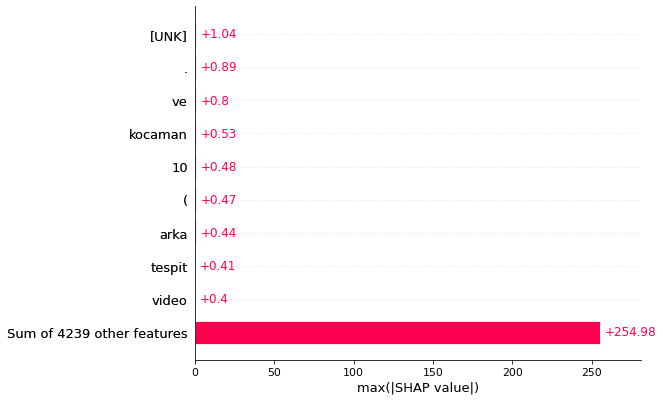

In [13]:
shap.plots.bar(shap_values.abs.max(0))

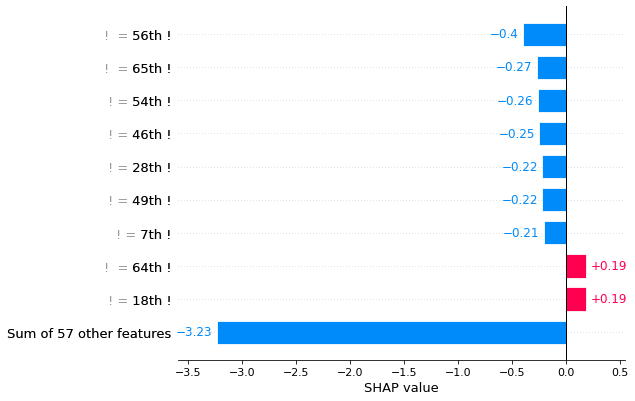

In [14]:
shap.plots.bar(shap_values[:,"!"])